#                                                           Improving Delivery Rate Performance on Olist e-Commerce
Alpha Team - DTIDSOL-02

- Josephine
- Rio
- Widya


### **Contents**

1. Business Problem Understanding
2. Data Cleaning and Understanding
3. EDA
4. Data analysis
5. Summary
6. Conclusion 
7. Limitation
8. Recommendations

****

# Problem Statement

Background and aim of analysis
Business problem identification 

# Data Understanding & Cleaning

## Import Libraries & Datasets

In [87]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind, kstest
import statsmodels.api as sm
import os
import missingno as msno

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_colwidth', None)

In [88]:
# List of date columns for each Olist dataset
# This dictionary maps each dataset filename to a list of columns that should be parsed as dates.
date_cols = {
    'olist_orders_dataset.csv': [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date',
    ],
    'olist_order_items_dataset.csv': [
        'shipping_limit_date',
    ],
    'olist_order_reviews_dataset.csv': [
        'review_creation_date',
        'review_answer_timestamp',
    ],
    # The following datasets have NO date columns:
    # 'olist_customers_dataset.csv'
    # 'olist_geolocation_dataset.csv'
    # 'olist_order_payments_dataset.csv'
    # 'olist_products_dataset.csv'
    # 'olist_sellers_dataset.csv'
    # 'product_category_name_translation.csv'
}

def read_olist_csv(path):
    """
    Reads an Olist CSV and parses dates for the correct columns.
    Args:
        path (str): Path to the CSV file.
    Returns:
        pd.DataFrame: Loaded dataframe with date columns parsed as datetime.
    """
    # Extract just the filename, e.g., 'olist_orders_dataset.csv'
    filename = os.path.basename(path)
    # Get the correct date columns for this file, or an empty list
    parse_dates = date_cols.get(filename, [])
    # Read the CSV, parsing the specified date columns (if any)
    return pd.read_csv(path, parse_dates=parse_dates)

Load original (raw) datasets:

In [89]:
original_df_orders           = read_olist_csv('../data/original_data/olist_orders_dataset.csv')
original_df_customers        = read_olist_csv('../data/original_data/olist_customers_dataset.csv')
original_df_order_items      = read_olist_csv('../data/original_data/olist_order_items_dataset.csv')
original_df_order_payments   = read_olist_csv('../data/original_data/olist_order_payments_dataset.csv')
original_df_reviews          = read_olist_csv('../data/original_data/olist_order_reviews_dataset.csv')
original_df_products         = read_olist_csv('../data/original_data/olist_products_dataset.csv')
original_df_prod_cat_tr      = read_olist_csv('../data/original_data/product_category_name_translation.csv')
original_df_sellers          = read_olist_csv('../data/original_data/olist_sellers_dataset.csv')
original_df_geolocation      = read_olist_csv('../data/original_data/olist_geolocation_dataset.csv')

Load cleaned datasets

In [90]:
cleaned_delivered_df_orders           = read_olist_csv('../data/cleaned_data/olist_orders_dataset.csv')
cleaned_df_customers        = read_olist_csv('../data/cleaned_data/olist_customers_dataset.csv')
cleaned_delivered_df_order_items      = read_olist_csv('../data/cleaned_data/olist_order_items_dataset.csv')
cleaned_delivered_df_order_payments   = read_olist_csv('../data/cleaned_data/olist_order_payments_dataset.csv')
cleaned_delivered_df_reviews          = read_olist_csv('../data/cleaned_data/olist_order_reviews_dataset.csv')
cleaned_df_products         = read_olist_csv('../data/cleaned_data/olist_products_dataset.csv')
cleaned_df_prod_cat_tr      = read_olist_csv('../data/cleaned_data/product_category_name_translation.csv')
cleaned_df_sellers          = read_olist_csv('../data/cleaned_data/olist_sellers_dataset.csv')
cleaned_df_geolocation      = read_olist_csv('../data/cleaned_data/olist_geolocation_dataset.csv')

Merge all datasets

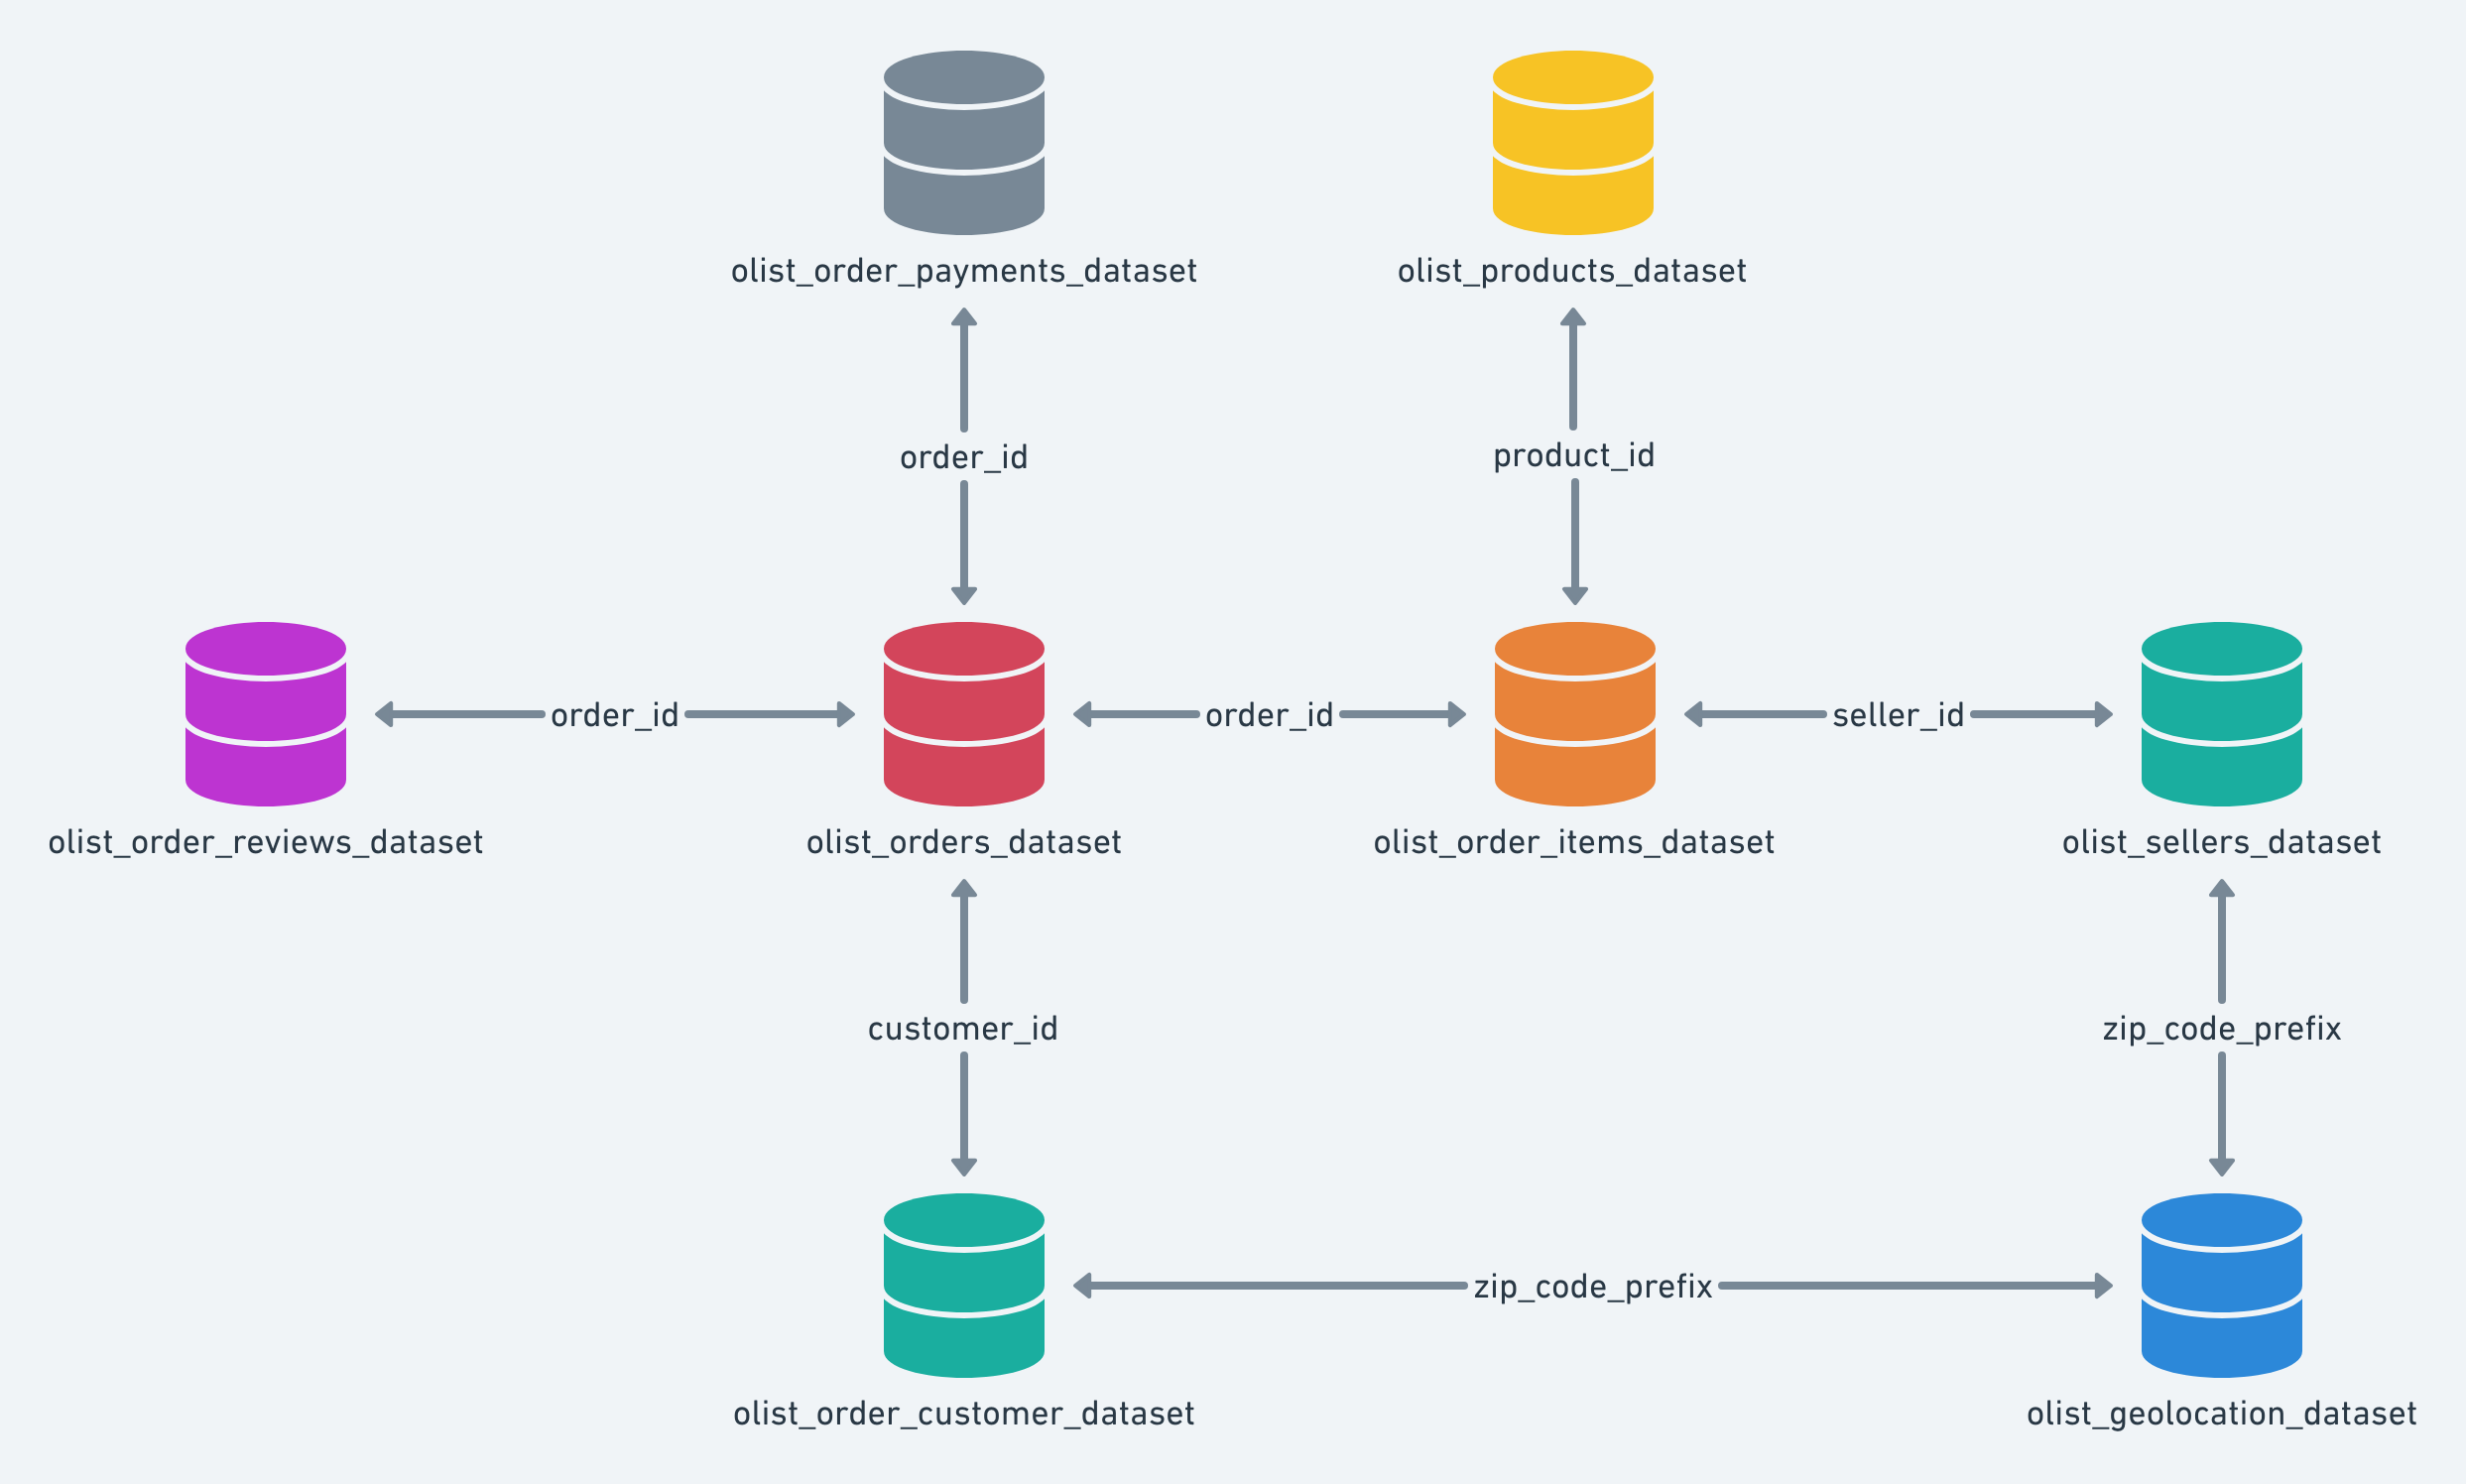

Orders with Customers

In [91]:
# Merge orders + customers (1:1)
merged_orders_customers = cleaned_delivered_df_orders.merge(
    cleaned_df_customers,
    on='customer_id',
    how='left',
    indicator=True
)
print("orders⇄customers:", merged_orders_customers['_merge'].value_counts())
assert (merged_orders_customers['_merge'] == 'both').all(), "⚠️ Some orders missing customers!"
merged_orders_customers.drop(columns=['_merge'], inplace=True)

display(merged_orders_customers.head())

orders⇄customers: _merge
both          96282
left_only         0
right_only        0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27.000000000,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23.000000000,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59.000000000,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29.000000000,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [92]:
merged_orders_customers.isna().sum()  # Check for any missing values in the merged DataFrame

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
dtype: int64

Order Items with Products

In [93]:
# Enrich order_items with products (1:1)
enriched_order_items = cleaned_delivered_df_order_items.merge(
    cleaned_df_products,
    on='product_id',
    how='left',
    indicator=True
)

print("order_items⇄products:", enriched_order_items['_merge'].value_counts())
# assert (enriched_order_items['_merge'] == 'both').all(), "⚠️ Some items missing products!"
# enriched_order_items.drop(columns=['_merge'], inplace=True)

display(enriched_order_items.head())

order_items⇄products: _merge
both          109936
left_only         17
right_only         0
Name: count, dtype: int64


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,_merge
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,both
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,both
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,both
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,both
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,both


In [94]:
enriched_order_items.isna().sum()  # Check for any missing values in the enriched DataFrame

order_id                       0
order_item_id                  0
product_id                     0
seller_id                      0
shipping_limit_date            0
price                          0
freight_value                  0
product_category_name         17
product_name_lenght           17
product_description_lenght    17
product_photos_qty            17
product_weight_g              17
product_length_cm             17
product_height_cm             17
product_width_cm              17
_merge                         0
dtype: int64

In [95]:
enriched_order_items[enriched_order_items['_merge'] == 'left_only']  # Check for items without products

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,_merge
6949,101157d4fae1c9fb74a00a5dee265c25,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-11 08:02:26,29.0,14.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9011,1521c6bb7b1028154c8c67cf80fa809f,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-07 10:10:16,29.0,16.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
28006,415cfaaaa8cea49f934470548797fed1,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-07 10:35:19,29.0,14.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
28007,415cfaaaa8cea49f934470548797fed1,2,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-07 10:35:19,29.0,14.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
38344,595316a07cd3dea9db7adfcc7e247ae7,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-08-18 04:26:04,39.0,9.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47252,6e150190fbe04c642a9cf0b80d83ee16,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-06-30 16:45:14,39.0,16.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
47790,6f497c40431d5fb0cfbd6c943dd29215,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-11 05:55:32,29.0,10.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
69432,a2456e7f02197951664897a94c87242d,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-04-06 11:50:09,29.0,24.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
71800,a7a43f469c0d7bdb0a23a82db125aefa,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-08-28 13:15:11,39.0,15.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
80822,bbfc7badbed2f1828e22b6d629201bd4,1,5eb564652db742ff8f28759cd8d2652a,4e922959ae960d389249c378d1c939f5,2017-07-18 04:04:10,39.0,11.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [96]:
# Remove order items that don't have matching products
print(f"Removing {(enriched_order_items['_merge'] == 'left_only').sum()} order items without matching products")
enriched_order_items = enriched_order_items[enriched_order_items['_merge'] == 'both']

Removing 17 order items without matching products


In [97]:
enriched_order_items.drop(columns=['_merge'], inplace=True)
enriched_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0


Order Items-Products with Sellers

In [98]:
# Enrich with sellers (1:1)
enriched_order_items = enriched_order_items.merge(
    cleaned_df_sellers,
    on='seller_id',
    how='left',
    indicator=True
)
print("enriched_order_items⇄sellers:", enriched_order_items['_merge'].value_counts())
assert (enriched_order_items['_merge'] == 'both').all(), "⚠️ Some items missing sellers!"
enriched_order_items.drop(columns=['_merge'], inplace=True)

enriched_order_items⇄sellers: _merge
both          109936
left_only          0
right_only         0
Name: count, dtype: int64


In [99]:
enriched_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564,borda da mata,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403,franca,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900,loanda,PR


Orders+Customers with Order Items+Products+Sellers

In [100]:
# Merge orders+customers ⇄ enriched order_items (1:many)
merged_orders_items = merged_orders_customers.merge(
    enriched_order_items,
    on='order_id',
    how='left',
    indicator=True
)
print("(orders+cust)⇄items:", merged_orders_items['_merge'].value_counts())
n_items = len(enriched_order_items)
matched_items = (merged_orders_items['_merge'] == 'both').sum()
assert matched_items == n_items, f"⚠️ Only {matched_items}/{n_items} items matched!"
# assert (merged_orders_items['_merge'] == 'left_only').sum() == 0, "⚠️ Some orders have no items!"
# merged_orders_items.drop(columns=['_merge'], inplace=True)

merged_orders_items.head()

(orders+cust)⇄items: _merge
both          109936
left_only         15
right_only         0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,both
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27.000000000,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,both
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23.000000000,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,both
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59.000000000,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,468.0,3.0,450.0,30.0,10.0,20.0,31842.0,belo horizonte,MG,both
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29.000000000,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,316.0,4.0,250.0,51.0,15.0,15.0,8752.0,mogi das cruzes,SP,both


15 orders has no items because those items were dropped due to missing product information. So, we'll drop these 15 orders

In [101]:
# Check the orders without items
orders_without_items = merged_orders_items[merged_orders_items['_merge'] == 'left_only']
print(f"Number of orders without items: {len(orders_without_items)}")

# Delete orders without items
print(f"Removing {(merged_orders_items['_merge'] == 'left_only').sum()} orders without matching items")
merged_orders_items = merged_orders_items[merged_orders_items['_merge'] == 'both']
merged_orders_items.drop(columns=['_merge'], inplace=True)

# Confirm the shape after removal
print(f"Final shape of merged_orders_items: {merged_orders_items.shape}")
merged_orders_items.head()

Number of orders without items: 15
Removing 15 orders without matching items
Final shape of merged_orders_items: (109936, 29)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27.000000000,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23.000000000,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59.000000000,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,59.0,468.0,3.0,450.0,30.0,10.0,20.0,31842.0,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29.000000000,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,38.0,316.0,4.0,250.0,51.0,15.0,15.0,8752.0,mogi das cruzes,SP


In [102]:
merged_orders_items.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state        

Orders+Items+Customers+Sellers+Products with Payments

In [103]:
# Merge that ⇄ payments (1:many)
merged_orders_payments = merged_orders_items.merge(
    cleaned_delivered_df_order_payments,
    on='order_id',
    how='left',
    indicator=True
)
print("with payments:", merged_orders_payments['_merge'].value_counts())
assert not (merged_orders_payments['_merge'] == 'right_only').any(), "⚠️ Orphan payments exist!"
# merged_orders_payments.drop(columns=['_merge'], inplace=True)

merged_orders_payments.head()

with payments: _merge
both          114761
left_only          3
right_only         0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.0,13.0,9350.0,maua,SP,1.0,credit_card,1.0,18.12,both
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.0,13.0,9350.0,maua,SP,3.0,voucher,1.0,2.00,both
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.0,13.0,9350.0,maua,SP,2.0,voucher,1.0,18.59,both
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27.000000000,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,13.0,19.0,31570.0,belo horizonte,SP,1.0,boleto,1.0,141.46,both
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23.000000000,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,19.0,21.0,14840.0,guariba,SP,1.0,credit_card,3.0,179.12,both


In [104]:
merged_orders_payments.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', '_merge'],
      dtype='object')

In [105]:
# Check for orders without payments
merged_orders_payments[merged_orders_payments['_merge'] == 'left_only'][['order_id', 'order_item_id', 'product_id',
                                                                         'payment_sequential', 'payment_type', 'payment_installments', 'payment_value',
                                                                         'price', 'freight_value']]

,order_id,order_item_id,product_id,payment_sequential,payment_type,payment_installments,payment_value,price,freight_value
35511,bfbd0f9bdef84302105ad712db648a6c,1.0,5a6b04657a4c5ee34285d1e4619a96b4,NaN,NaN,NaN,NaN,44.99,2.83
35512,bfbd0f9bdef84302105ad712db648a6c,2.0,5a6b04657a4c5ee34285d1e4619a96b4,NaN,NaN,NaN,NaN,44.99,2.83
35513,bfbd0f9bdef84302105ad712db648a6c,3.0,5a6b04657a4c5ee34285d1e4619a96b4,NaN,NaN,NaN,NaN,44.99,2.83


In [106]:
original_df_order_payments[original_df_order_payments['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c']

,order_id,payment_sequential,payment_type,payment_installments,payment_value


Reasoning for keeping the row:

There is 1 order (3 items) that contains missing payment info, even on the original payments dataset. The `payment_value` can be inferred by calculating `price + freight_value`. However, the rest of the info can only be imputed with synthetic values. So, we'll infer what we can and flag this order that it contains synthetic payment info.

In [107]:
# original_df_order_payments['payment_type'].value_counts()

In [108]:
# missing_payment_mask = merged_orders_payments['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c'

# # Calculate the payment value from price + freight_value
# merged_orders_payments.loc[missing_payment_mask, 'payment_value'] = (
#     merged_orders_payments.loc[missing_payment_mask, 'price'] + 
#     merged_orders_payments.loc[missing_payment_mask, 'freight_value']
# )

# # Set payment type to 'not_defined' (synthetic value, but this category exists in the original dataset)
# merged_orders_payments.loc[missing_payment_mask, 'payment_type'] = 'not_defined'

# # Add a flag to indicate this order has synthetic payment data
# merged_orders_payments['missing_payment_details'] = False
# merged_orders_payments.loc[missing_payment_mask, 'missing_payment_details'] = True

# merged_orders_payments[missing_payment_mask]

Delete the row approach:

In [109]:
# Delete the 3 rows with missing payment info instead of keeping them
print(f"Removing {(merged_orders_payments['_merge'] == 'left_only').sum()} orders without payment information")
merged_orders_payments = merged_orders_payments[merged_orders_payments['_merge'] == 'both']

Removing 3 orders without payment information


In [110]:
merged_orders_payments.drop(columns=['_merge'], inplace=True)
merged_orders_payments.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,19.0,8.0,13.0,9350.0,maua,SP,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,19.0,8.0,13.0,9350.0,maua,SP,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,19.0,8.0,13.0,9350.0,maua,SP,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27.000000000,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,19.0,13.0,19.0,31570.0,belo horizonte,SP,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23.000000000,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,24.0,19.0,21.0,14840.0,guariba,SP,1.0,credit_card,3.0,179.12


In [111]:
merged_orders_payments.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
seller_zip_code_prefix           0
seller_city                      0
seller_state        

Orders+Items+Customers+Sellers+Products+Payments with Reviews

In [112]:
# Merge enriched_orders ⇄ reviews (1:1)
merged_orders_reviews = merged_orders_payments.merge(
    cleaned_delivered_df_reviews,
    on='order_id',
    how='left',
    indicator=True
)
print("with reviews:", merged_orders_reviews['_merge'].value_counts())
assert not (merged_orders_reviews['_merge'] == 'right_only').any(), "⚠️ Orphan reviews exist!"
# merged_orders_reviews.drop(columns=['_merge'], inplace=True)

merged_orders_reviews.head()

with reviews: _merge
both          113721
left_only       1372
right_only         0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,both
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,both
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,both
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27.000000000,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,both
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23.000000000,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18,2018-08-22 19:07:58,both


In [113]:
merged_orders_reviews[merged_orders_reviews['_merge'] == 'left_only']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,_merge
19,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04.000000000,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06,6e26bbeaa107ec34112c64e1ee31c0f5,21381,...,credit_card,10.0,1376.45,NaN,NaN,NaN,NaN,NaT,NaT,left_only
65,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36.000000000,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03-30,51838d41add414a0b1b989b7d251d9ee,13068,...,boleto,1.0,99.26,NaN,NaN,NaN,NaN,NaT,NaT,left_only
98,b8801cccd8068de30112e4f49903d74a,f26a435864aebedff7f7c84f82ee229f,delivered,2017-07-30 03:06:35,2017-07-30 03:25:08.000000000,2017-07-31 16:42:54,2017-08-01 14:27:31,2017-08-16,bb4d84a2b45b22ed710ac8c0dec63d1a,8552,...,credit_card,2.0,27.77,NaN,NaN,NaN,NaN,NaT,NaT,left_only
209,ce9feeba53c652dd6569cca62e2bb287,f7398fc942c8fa80e5419ae52e49f7fb,delivered,2018-04-15 19:42:06,2018-04-15 19:55:20.000000000,2018-04-19 14:32:30,2018-04-20 23:12:11,2018-04-26,d01cf8c6c7c836c5dd9320585928f42b,6414,...,credit_card,1.0,56.86,NaN,NaN,NaN,NaN,NaT,NaT,left_only
287,7e3e92dc3eaf5389f32da97228f7dd0e,62d50e9a714ac024c196d9548594e2aa,delivered,2017-07-02 20:47:24,2017-07-02 21:03:55.000000000,2017-07-03 11:42:08,2017-07-11 20:22:31,2017-07-25,ba77e9b6506636dcbd03e463d4786f24,95059,...,credit_card,4.0,95.21,NaN,NaN,NaN,NaN,NaT,NaT,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114635,2fcdb0c004a2a538d3dd724ea76916bd,cf826be53b1fe4a39bc33c7f5f827835,delivered,2017-11-22 11:39:00,2017-11-22 11:49:05,2017-11-23 22:58:51,2017-12-15 00:23:25,2017-12-18,d92462d83762d5e5c112bccc344119e6,65940,...,credit_card,9.0,90.71,NaN,NaN,NaN,NaN,NaT,NaT,left_only
114735,2f2df159f26ddb73d55ee72372200d3e,86a7245fffe6a418ca1658a13ecc4531,delivered,2017-07-17 01:19:50,2017-07-17 01:30:09,2017-07-17 22:14:50,2017-07-26 09:44:00,2017-08-09,1d532194f005426adcdf6d969640d56e,35240,...,credit_card,8.0,166.81,NaN,NaN,NaN,NaN,NaT,NaT,left_only
114808,129c72226e320a7bf5b89efce442afd5,46dbd6b44084696774eb0bc59352069a,delivered,2018-02-12 03:09:04,2018-02-12 03:48:19,2018-02-15 05:41:47,2018-02-28 17:07:46,2018-03-12,ae8482b27b2119e2c3278f5ddf9c1024,4941,...,credit_card,2.0,87.55,NaN,NaN,NaN,NaN,NaT,NaT,left_only
114839,f0dd9af88d8ef5a8e4670fbbedaf19c4,30ddb50bd22ee927ebe308ea3da60735,delivered,2017-09-02 20:38:29,2017-09-05 04:24:12,2017-09-14 23:13:41,2017-09-15 14:59:50,2017-09-19,1d627d8a6e1e33ea8eeeb7a17d998660,11045,...,boleto,1.0,100.25,NaN,NaN,NaN,NaN,NaT,NaT,left_only


There are 1372 order items that have no reviews. This is fine since reviews are optional. So, we'll introduce a flag `has_review` to mark if an order item has a review or not.

In [114]:
# Add an explicit flag
merged_orders_reviews['has_review'] = merged_orders_reviews['review_id'].notna()
merged_orders_reviews[merged_orders_reviews['_merge'] == 'left_only'].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,_merge,has_review
19,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04.000000000,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06,6e26bbeaa107ec34112c64e1ee31c0f5,21381,...,10.0,1376.45,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False
65,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,delivered,2017-03-13 18:14:36,2017-03-13 18:14:36.000000000,2017-03-22 14:03:09,2017-04-06 13:37:16,2017-03-30,51838d41add414a0b1b989b7d251d9ee,13068,...,1.0,99.26,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False
98,b8801cccd8068de30112e4f49903d74a,f26a435864aebedff7f7c84f82ee229f,delivered,2017-07-30 03:06:35,2017-07-30 03:25:08.000000000,2017-07-31 16:42:54,2017-08-01 14:27:31,2017-08-16,bb4d84a2b45b22ed710ac8c0dec63d1a,8552,...,2.0,27.77,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False
209,ce9feeba53c652dd6569cca62e2bb287,f7398fc942c8fa80e5419ae52e49f7fb,delivered,2018-04-15 19:42:06,2018-04-15 19:55:20.000000000,2018-04-19 14:32:30,2018-04-20 23:12:11,2018-04-26,d01cf8c6c7c836c5dd9320585928f42b,6414,...,1.0,56.86,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False
287,7e3e92dc3eaf5389f32da97228f7dd0e,62d50e9a714ac024c196d9548594e2aa,delivered,2017-07-02 20:47:24,2017-07-02 21:03:55.000000000,2017-07-03 11:42:08,2017-07-11 20:22:31,2017-07-25,ba77e9b6506636dcbd03e463d4786f24,95059,...,4.0,95.21,NaN,NaN,NaN,NaN,NaT,NaT,left_only,False


In [115]:
merged_orders_reviews.drop(columns=['_merge'], inplace=True)
merged_orders_reviews.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      0
product_length_cm                     0
product_height_cm                     0


Complete Orders with Product Category Translation

In [116]:
# Merge complete orders ⇄ category translation
merged_orders_translated = merged_orders_reviews.merge(
    cleaned_df_prod_cat_tr,
    on='product_category_name',
    how='left',
    indicator=True
)
print("with category translation:", merged_orders_translated['_merge'].value_counts())
# assert (merged_orders_category['_merge'] == 'both').all(), "⚠️ Missing category translations!"
# merged_orders_category.drop(columns=['_merge'], inplace=True)

merged_orders_translated.head()

with category translation: _merge
both          113455
left_only       1638
right_only         0
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,has_review,product_category_name_english,_merge
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,True,housewares,both
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,True,housewares,both
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15.000000000,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,True,housewares,both
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27.000000000,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,True,perfumery,both
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23.000000000,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18,2018-08-22 19:07:58,True,auto,both


In [117]:
merged_orders_translated.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'has_review',
       'product_category_name_english', '_merge'],
      dtype='object')

In [118]:
merged_orders_translated[merged_orders_translated['_merge'] == 'left_only'][['product_category_name', 'product_category_name_english']].head(10)

,product_category_name,product_category_name_english
126,unknown_category,NaN
215,unknown_category,NaN
268,unknown_category,NaN
309,unknown_category,NaN
381,unknown_category,NaN
537,unknown_category,NaN
598,unknown_category,NaN
785,unknown_category,NaN
814,unknown_category,NaN
1061,portateis_cozinha_e_preparadores_de_alimentos,NaN


1638 order items does not have an English translation for the products that were sold. There's a `unknown_category` value which naturally has no translation, so we can fill the missing values with the exact same value for that case.

In [119]:
# Replace missing English translations for unknown_category
mask_unknown = merged_orders_translated['product_category_name'] == 'unknown_category'
merged_orders_translated.loc[mask_unknown, 'product_category_name_english'] = 'unknown_category'

# Check the result
print(f"Number of items with 'unknown_category': {mask_unknown.sum()}")

Number of items with 'unknown_category': 1615


Apparently, there are 1615 items with no translation simply because their category is unknown. So, there are only 23 items left with purely no translation.

In [120]:
merged_orders_translated[merged_orders_translated['product_category_name_english'].isna()][['product_category_name', 'product_category_name_english']]

,product_category_name,product_category_name_english
1061,portateis_cozinha_e_preparadores_de_alimentos,NaN
2560,pc_gamer,NaN
8609,portateis_cozinha_e_preparadores_de_alimentos,NaN
10422,portateis_cozinha_e_preparadores_de_alimentos,NaN
12977,portateis_cozinha_e_preparadores_de_alimentos,NaN
13425,pc_gamer,NaN
19861,portateis_cozinha_e_preparadores_de_alimentos,NaN
30918,portateis_cozinha_e_preparadores_de_alimentos,NaN
30919,portateis_cozinha_e_preparadores_de_alimentos,NaN
42410,pc_gamer,NaN


The only 2 product category with no English translation here is "portateis_cozinha_e_preparadores_de_alimentos" and "pc_gamer". We will manually translate these categories since there are only 2 of them.

In [121]:
# Manually translate the missing product category names
translations = {
    'portateis_cozinha_e_preparadores_de_alimentos': 'portable_kitchen_food_processors',
    'pc_gamer': 'gaming_pc'
}

# Apply the translations
for pt_category, en_category in translations.items():
    mask = merged_orders_translated['product_category_name'] == pt_category
    merged_orders_translated.loc[mask, 'product_category_name_english'] = en_category

# Verify all categories now have translations
missing_translations = merged_orders_translated[merged_orders_translated['product_category_name_english'].isna()]
print(f"Number of items still missing translations: {len(missing_translations)}")

Number of items still missing translations: 0


In [122]:
merged_orders_translated.drop(columns=['_merge'], inplace=True)
merged_orders_translated.isna().sum()  # Check for any missing values in the final merged DataFrame

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      0
product_length_cm                     0
product_height_cm                     0


Final Master Dataset

In [123]:
master_olist_dataset = merged_orders_translated.copy()

# Final check & export
print("Final master table shape:", master_olist_dataset.shape)
master_olist_dataset.to_csv('../data/cleaned_data/master_olist_dataset.csv', index=False)
print("Saved master_olist_dataset.csv")

Final master table shape: (115093, 41)
Saved master_olist_dataset.csv


In [124]:
master_olist_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115093 non-null  object        
 1   customer_id                    115093 non-null  object        
 2   order_status                   115093 non-null  object        
 3   order_purchase_timestamp       115093 non-null  datetime64[ns]
 4   order_approved_at              115093 non-null  object        
 5   order_delivered_carrier_date   115093 non-null  object        
 6   order_delivered_customer_date  115093 non-null  datetime64[ns]
 7   order_estimated_delivery_date  115093 non-null  datetime64[ns]
 8   customer_unique_id             115093 non-null  object        
 9   customer_zip_code_prefix       115093 non-null  int64         
 10  customer_city                  115093 non-null  object        
 11  

# EDA

## Sales

In [125]:
df_sales = master_olist_dataset[['order_id','seller_id', 'customer_id', 'order_status', 'order_purchase_timestamp','price']].copy()

In [126]:
df_sales.head()

,order_id,seller_id,customer_id,order_status,order_purchase_timestamp,price
0,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,29.99
1,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,29.99
2,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,29.99
3,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,118.70
4,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,159.90


In [127]:
df_sales.nunique()


order_id                    96266
seller_id                    2965
customer_id                 96266
order_status                    1
order_purchase_timestamp    95745
price                        5857
dtype: int64

In [128]:
# sales per month with number of orders and buyers

df_sales['Year-Month (Purchase)'] = df_sales['order_purchase_timestamp'].dt.to_period('M')
df_sales['Year-Month (Purchase)'] = df_sales['Year-Month (Purchase)'].dt.to_timestamp()

monthly_sales = df_sales.groupby('Year-Month (Purchase)').agg(
    monthly_revenue = ('price','sum'),
    total_orders = ('order_id', 'count'),
    total_buyers = ('customer_id', 'nunique'),
    total_sellers = ('seller_id', 'nunique')
).reset_index()

print("Monthly sales data:")
monthly_sales




Monthly sales data:


,Year-Month (Purchase),monthly_revenue,total_orders,total_buyers,total_sellers
0,2016-10-01,41179.54,328,261,128
1,2016-12-01,10.90,1,1,1
2,2017-01-01,120156.45,965,749,218
3,2017-02-01,246365.95,1962,1651,401
4,2017-03-01,381774.29,3082,2542,475
5,2017-04-01,361207.47,2703,2297,488
6,2017-05-01,530113.68,4281,3544,562
7,2017-06-01,443331.91,3698,3132,518
8,2017-07-01,514498.77,4705,3859,590
9,2017-08-01,581117.84,5077,4189,683


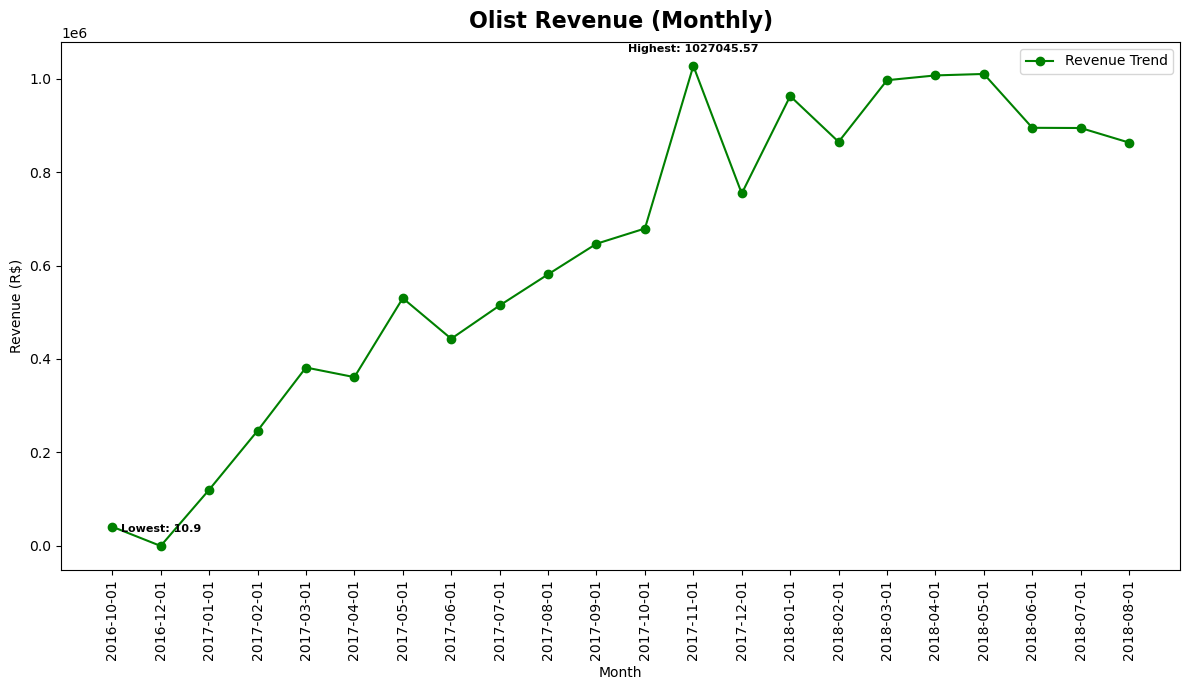

In [129]:
plt.figure(figsize=(12, 7))
monthlyprofit_values = monthly_sales['monthly_revenue'].replace('R$', '').astype(float)
plt.plot(monthly_sales['Year-Month (Purchase)'].astype(str), monthlyprofit_values, marker='o', linestyle='-', color='green',label='Revenue Trend')

# Finding the index of the highest and lowest values
max_index_p = monthlyprofit_values.idxmax()
min_index_p = monthlyprofit_values.idxmin()

# highest and lowest values
plt.annotate(f"Highest: {monthly_sales['monthly_revenue'][max_index_p]}", 
             (monthly_sales['Year-Month (Purchase)'].astype(str)[max_index_p], monthlyprofit_values[max_index_p]),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, fontweight='bold')
plt.annotate(f"Lowest: {monthly_sales['monthly_revenue'][min_index_p]}", 
             (monthly_sales['Year-Month (Purchase)'].astype(str)[min_index_p], monthlyprofit_values[min_index_p]),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, fontweight='bold')

plt.xlabel('Month')
plt.ylabel('Revenue (R$)')
plt.title('Olist Revenue (Monthly)', size=16, pad=10, fontweight='bold')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

plt.show()

In [130]:
print('Multilines Chart of Monthly Sales:')

#Plotly figure with multilines chart
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_orders'],
    mode='lines+markers',
    name='Total Orders'
))

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_buyers'],
    mode='lines+markers',
    name='Total Buyers'
))

fig.add_trace(go.Scatter(
    x=monthly_sales['Year-Month (Purchase)'],
    y=monthly_sales['total_sellers'],
    mode='lines+markers',
    name='Total Sellers'
))

fig.update_layout(
    title='Total Orders, Buyers, and Sellers (Monthly)', title_x=0.5,
    xaxis_title='Month',
    yaxis_title='Count',
    legend_title='Metric',
    template='plotly_white'
)

Multilines Chart of Monthly Sales:


## Customers

In [181]:
df_customers_geo = master_olist_dataset[['customer_id','customer_unique_id','customer_zip_code_prefix','customer_state','customer_city']].reset_index()


In [ ]:
df_customers_state = master_olist_dataset[['customer_unique_id', 'customer_state']].drop_duplicates().reset_index(drop=True)


,customer_unique_id,customer_state
0,7c396fd4830fd04220f754e42b4e5bff,SP
1,af07308b275d755c9edb36a90c618231,BA
2,3a653a41f6f9fc3d2a113cf8398680e8,GO
3,7c142cf63193a1473d2e66489a9ae977,RN
4,72632f0f9dd73dfee390c9b22eb56dd6,SP


In [187]:
top_state = df_customers_state['customer_state'].value_counts().nlargest(10).reset_index()
top_state

,customer_state,count
0,SP,39080
1,RJ,11898
2,MG,10974
3,RS,5149
4,PR,4756
5,SC,3437
6,BA,3154
7,DF,2015
8,ES,1922
9,GO,1889


In [172]:
# Customer state distribution:
fig = px.histogram(
    df_customers_state,
    x='customer_state',
    title='Number of Customers by State',
    labels={'customer_state': 'State'},
    color='customer_state',                     
    color_discrete_sequence=px.colors.qualitative.Plotly,
      
)

fig.update_layout(
    xaxis_title='State',
    yaxis_title='Number of Customers',
    template='plotly_white'
)   
fig.show()


In [185]:
top_cities = df_customers_geo['customer_city'].value_counts().nlargest(20).reset_index()
top_cities

,customer_city,count
0,sao paulo,18205
1,rio de janeiro,7958
2,belo horizonte,3186
3,brasilia,2414
4,curitiba,1783
5,campinas,1711
6,porto alegre,1610
7,salvador,1473
8,guarulhos,1361
9,sao bernardo do campo,1096


In [189]:
# Customer city distribution (top 20):
top_cities = df_customers_geo['customer_city'].value_counts().nlargest(20).reset_index()
top_cities.columns = ['city', 'count']

fig = px.bar(
    top_cities,
    x='city',
    y='count',
    title='Top 20 Customers Cities',
    color='count',
    color_continuous_scale='Oxy'
)

fig.update_layout(
    xaxis_title='Cities',
    yaxis_title='Counts',
    template='plotly_white'
)  
fig.show()

In [ ]:
# Interactive map of customers by location:
fig = px.scatter_mapbox(
    df_customers_geo,
    lat='geolocation_lat',
    lon='geolocation_lng',
    hover_name='customer_city',
    hover_data={'customer_state': True, 'customer_zip_code_prefix': True},
    color='customer_state',
    zoom=3,
    height=600,
    title='Interactive Map of Customers by Location',
)

# Set mapbox style:
fig.update_layout(mapbox_style='carto-positron')
fig.update_layout(margin={'r':0, 't':40, 'l':0, 'b':0})
fig.show()